In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4  #length of the sentence
batch_size = 1
input_dim = 512
d_model = 512  #output dim
x = torch.randn((batch_size, sequence_length, input_dim))

In [3]:
x.size()  #random generatedinput , normally inputembedding + positional embedding

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3* d_model)  #qkv concatenates so 3*

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv Distribution')

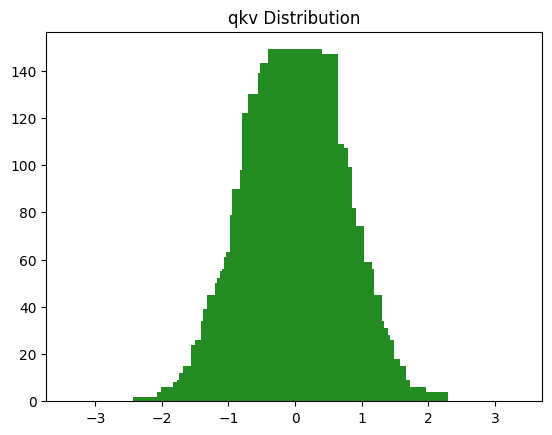

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins= 200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01)*3
plt.bar(x_val, y_val, align= "center", color=["forestgreen"])
plt.title('qkv Distribution')

In [11]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)

In [12]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [13]:
 qkv = qkv.permute(0, 2, 1, 3) #[batch_size. num_heads, sequence_length, 3*head_dim]
 qkv.shape

torch.Size([1, 8, 4, 192])

In [15]:
q, k, v = qkv.chunk(3, dim =-1) #-1 to divide 192 into qkv separately
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

****

<font face="Times New Roman" size=6 color='#d39aed'> SELF ATTENTION for multiple Heads<font>

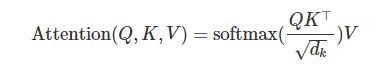

In [17]:
import math
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)  # transpose because 4d tensor and tranpose across only last two
scaled.shape


torch.Size([1, 8, 4, 4])

In [18]:
k.T.shape

torch.Size([64, 4, 8, 1])

Check with random tensors

In [19]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[ 1.3570,  1.8121],
        [-0.6482,  2.0104],
        [ 1.6205, -1.1252]])

In [20]:
torch.transpose(y, 1, 0)

tensor([[ 1.3570,  1.8121],
        [-0.6482,  2.0104],
        [ 1.6205, -1.1252]])

In [21]:
k.transpose(-1, -2) == k.transpose(-2, -1) #as long as same dim they both are same

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [22]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [23]:
mask = torch.full(scaled.size(), float("-inf"))
mask = torch.triu(mask , diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [25]:
(scaled + mask)[0][0]

tensor([[-0.0432,    -inf,    -inf,    -inf],
        [ 0.2038, -0.4118,    -inf,    -inf],
        [-0.0947,  0.3726, -0.3709,    -inf],
        [-0.4409,  0.2071,  0.1299, -0.5504]], grad_fn=<SelectBackward0>)

In [26]:
scaled += mask

In [27]:
np.exp( 0.2038) / (np.exp( 0.2038)+ np.exp(-0.4118)) # for the second lin e in the tensor

0.6492171770154882

In [28]:
attention = F.softmax(scaled, dim =-1)

In [29]:
attention.shape

torch.Size([1, 8, 4, 4])

In [30]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6492, 0.3508, 0.0000, 0.0000],
        [0.2981, 0.4757, 0.2262, 0.0000],
        [0.1793, 0.3427, 0.3173, 0.1607]], grad_fn=<SelectBackward0>)

In [ ]:
#2nd line- 0.6492 as we have cal above

In [31]:
values = torch.matmul(attention, v)

In [32]:
values.shape

torch.Size([1, 8, 4, 64])

****
<font face="Times New Roman" size=6 color='#d39aed'> FUNCTION<font>

In [33]:
import math

def scaled_dot_product(q, k, v, mask= None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)

  if mask is not None:
    scaled+= mask

  attention = F.softmax(scaled, dim = -1)
  values = torch.matmul(attention, v)
  return values, attention

In [34]:
values, attention = scaled_dot_product(q, k, v , mask = mask)

In [35]:
attention.shape

torch.Size([1, 8, 4, 4])

In [36]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6492, 0.3508, 0.0000, 0.0000],
        [0.2981, 0.4757, 0.2262, 0.0000],
        [0.1793, 0.3427, 0.3173, 0.1607]], grad_fn=<SelectBackward0>)

In [37]:
values.size()

torch.Size([1, 8, 4, 64])

In [39]:
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [40]:
linear_layer = nn.Linear(d_model , d_model)

In [41]:
out = linear_layer(values)

In [42]:
out.shape

torch.Size([1, 4, 512])

In [43]:
out

tensor([[[ 0.2248, -0.1336,  0.3504,  ..., -0.0884,  0.0048, -0.0360],
         [ 0.0257,  0.0577, -0.0973,  ..., -0.2219, -0.0173, -0.1054],
         [ 0.0917,  0.3376, -0.1553,  ..., -0.3293,  0.0880,  0.3706],
         [-0.2448,  0.0179,  0.0812,  ...,  0.1565,  0.0213,  0.2606]]],
       grad_fn=<ViewBackward0>)

****
<font face="Times New Roman" size=6 color='#d39aed'> Wrapping all in a CLASS<font>

In [47]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask = None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)

  if mask is not None:
    scaled+= mask

  attention = F.softmax(scaled, dim = -1)
  values = torch.matmul(attention, v)

  return values, attention

class MultiheadAttention(nn.Module):

  def __init__(self, input_dim, d_model , num_heads):
    super().__init__()
    self.input_dim = input_dim   #input_dim
    self.d_model = d_model       #output_dim
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(input_dim , 3* d_model)
    self.linear_layer = nn.Linear(d_model, d_model)  #(in, out)

  def forward(self, x, mask = None):
    batch_size , sequence_length, input_dim = x.size()
    print(f"x.size(): {x.size()}")

    qkv = self.qkv_layer(x)
    print(f"qkv.size(): {qkv.size()}")

    qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3*self.head_dim)
    print(f"qkv.size():{qkv.size()}")

    qkv= qkv.permute(0, 2, 1, 3) # batch_size, num_heads, sequence_length, 3*head_dim
    print(f"qkv.size(): {qkv.size()}")

    q, k, v = qkv.chunk(3, dim =-1)  #split the tensor into chunks
    print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")

    values, attention = scaled_dot_product(q, k, v, mask)
    print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")

    values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
    print(f"values.size(): {values.size()}")

    out = self.linear_layer(values)
    print(f"out.size(): {out.size()}")

    return out


****
**INPUT**

In [48]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 20
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model ,num_heads)
out = model.forward(x)

x.size(): torch.Size([20, 5, 1024])
qkv.size(): torch.Size([20, 5, 1536])
qkv.size():torch.Size([20, 5, 8, 192])
qkv.size(): torch.Size([20, 8, 5, 192])
q size: torch.Size([20, 8, 5, 64]), k size: torch.Size([20, 8, 5, 64]), v size: torch.Size([20, 8, 5, 64]), 
values.size(): torch.Size([20, 8, 5, 64]), attention.size:torch.Size([20, 8, 5, 5]) 
values.size(): torch.Size([20, 5, 512])
out.size(): torch.Size([20, 5, 512])
